In [16]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import join, isfile

# info tables
infotable = f'/data01/homes/dipiano/E4/irf_random/crab/sim/merged_simulator_data.dat'

# dataset 
mapsname = '/data01/homes/dipiano/E4/irf_random/crab/regressor_100s_5sgm_10000sz_200x200_YESnorm_NOstretch.npy'
ds = np.load(mapsname, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
print(f"Maps: {ds.keys()}")
print(f"DS dataset size: {len(ds['DS'])}")

Maps: dict_keys(['DS', 'LABELS'])
DS dataset size: 10000


In [17]:
from astroai.tools.utils import split_regression_dataset

binning = 200
train_data, train_labels, test_data, test_labels = split_regression_dataset(ds, split=80, reshape=True, 
                                                                            binning=binning)

print(f"Train dataset: {len(train_data)}, {train_data.shape}")
print(f"Train labels: {len(train_labels)}, {train_labels.shape}")
print(f"\nTest dataset: {len(test_data)}, {test_data.shape}")
print(f"Test labels: {len(test_labels)}, {test_labels.shape}")

(8000, 200, 200) (8000, 2)
Train dataset: 8000, (8000, 200, 200, 1)
Train labels: 8000, (8000, 2)

Test dataset: 2000, (2000, 200, 200, 1)
Test labels: 2000, (2000, 2)


In [18]:
import numpy as np
from astroai.tools.utils import plot_heatmap, set_wcs

# get random seed
idx = np.random.choice(range(len(test_data)))
# find seed to get the original heatmap
seed = len(train_data) + idx + 1

# get simulation data
infodata = pd.read_csv(infotable, sep=' ', header=0).sort_values(by=['seed'])
row = infodata[infodata['seed']==seed]
row

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
9787,crab_09788,9788,0,100,100,236.635806,52.710069,236.576169,52.896433,0.18982,North_z60_S_50h_LST,2.5,6.434183


# Load model and weights

In [19]:
import tensorflow as tf

savename = 'regressor_200x200_filter2_90kp_4convs' 
model = tf.keras.models.load_model(f'../models/{savename}.keras')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 197, 197, 2)       34        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 2)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 4)         36        
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 4)         68        
                                                                 
 conv2d_3 (Conv2D)           (None, 95, 95, 4)         68        
                                                                 
 conv2d_4 (Conv2D)           (None, 94, 94, 4)         68        
                                                        

In [20]:
%time
predictions = model.predict(test_data) * binning
predictions[idx], test_labels[idx] * binning

CPU times: user 9 µs, sys: 3 µs, total: 12 µs
Wall time: 26.7 µs
63/63 [==============================] - 1s 16ms/step


(array([99.90038, 93.37661], dtype=float32), array([97.56725326, 91.5585346 ]))

In [21]:
from astroai.tools.utils import *

binning = 200
pixelsize = (2 * row['fov'].values[0]) / binning
point_ref = (binning / 2) + (pixelsize / 2)
w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
            point_ref=point_ref, pixelsize=pixelsize)
point_ref, pixelsize

x, y = predictions[idx][0], predictions[idx][1]
xl, yl = test_labels[idx][0], test_labels[idx][1]

sky = w.pixel_to_world(x, y)
f"PREDICTION: ({sky.ra.deg}, {sky.dec.deg}) TRUE: ({row['source_ra'].values[0]}, {row['source_dec'].values[0]})"

'PREDICTION: (236.54000956473794, 52.75521810123331) TRUE: (236.63580605107376, 52.71006923200595)'

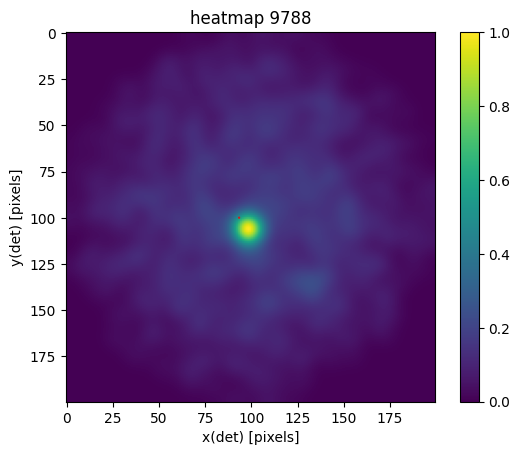

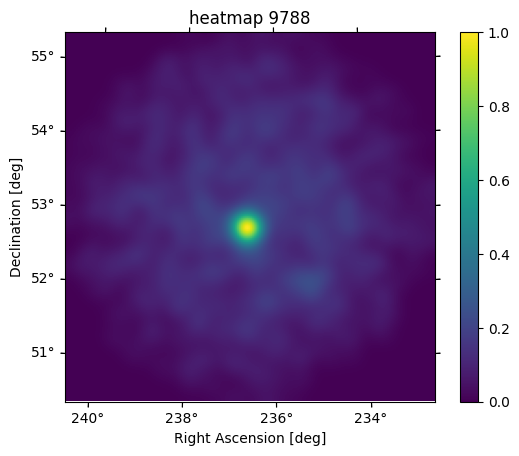

In [22]:
# plot map and prediction  
plot_heatmap(np.flipud(test_data[idx]), title=f'heatmap {seed}', show=True, 
             add_markers={'SRC': {'x': x, 'y': y, 'r': 0.2}})

# plot map and prediction wcs=w, 
plot_heatmap_wcs(test_data[idx], wcs=w, title=f'heatmap {seed}', show=True, 
                 add_markers={'SRC': {'x': sky.ra.deg, 'y': sky.dec.deg, 'r': 0.2}})

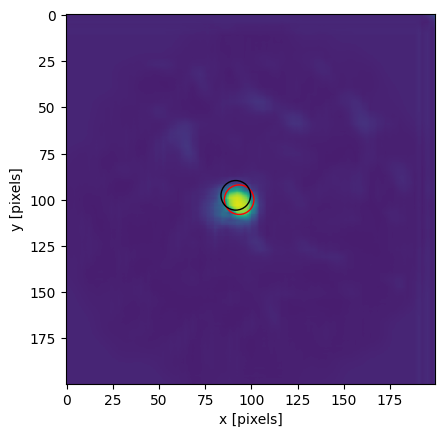

In [36]:
yx = y, x
yxl = yl * binning, xl * binning
radius_pix = 0.2/0.025

ax = plt.subplot()
ax.imshow(np.rot90(test_data[idx]), vmin=0, vmax=1)
ax.add_patch(plt.Circle(yx, radius=radius_pix, edgecolor='r', facecolor='none'))
ax.add_patch(plt.Circle(yxl, radius=radius_pix, edgecolor='k', facecolor='none'))
ax.set_ylabel('y [pixels]')
ax.set_xlabel('x [pixels]')

plt.show()

# Plot loss

In [24]:
loss = model.evaluate(test_data, test_labels, verbose=2)

63/63 - 1s - loss: 0.1301 - accuracy: 0.5320 - 1s/epoch - 19ms/step


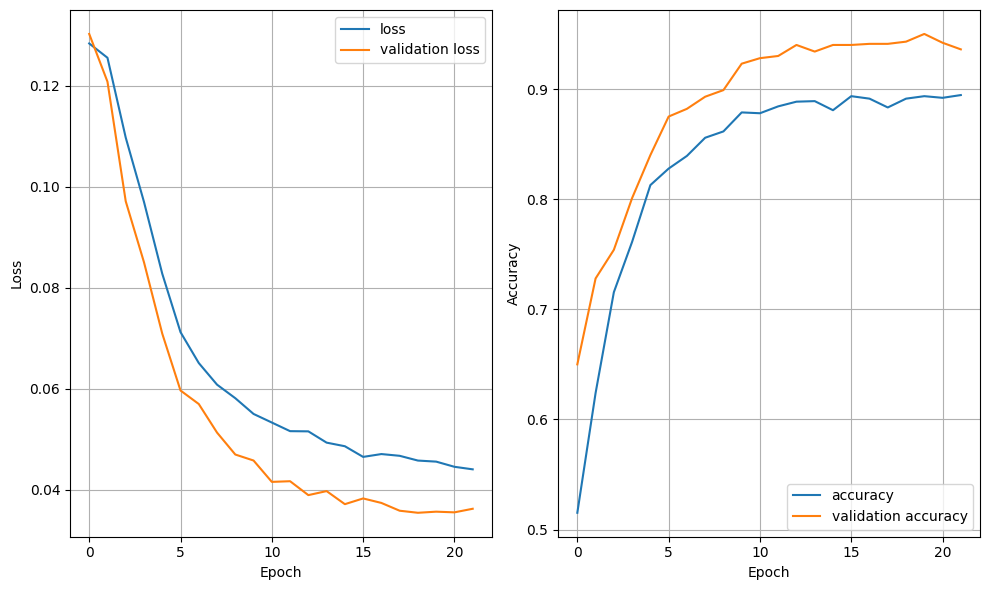

In [25]:
import matplotlib.pyplot as plt

history = np.load(f'/data01/homes/dipiano/astroAI/astroai/models/{savename}_history.npy', 
                  allow_pickle='TRUE').item()


fig, ax = plt.subplots(1, 2, figsize=(10, 6))

ax[0].plot(history['loss'], label='loss')
ax[0].plot(history['val_loss'], label = 'validation loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
#ax.set_ylim([0.2,0.65])
ax[0].grid()
ax[0].legend(loc=0)

ax[1].plot(history['accuracy'], label='accuracy')
ax[1].plot(history['val_accuracy'], label = 'validation accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
#ax.set_ylim([0.2,0.65])
ax[1].grid()
ax[1].legend(loc=0)

plt.tight_layout()
plt.show()

# Get separation error

In [26]:
from astroai.tools.utils import *
from astropy.coordinates import SkyCoord

# get true coordinates in SkyCoord
true = SkyCoord(ra=row['source_ra'].values[0], dec=row['source_dec'].values[0], unit='deg', frame='icrs')

# get errors
err = true.separation(sky)

print(f"TRUE: ({true.ra.deg}, {true.dec.deg})\n")
print(f"PREDICTION: ({sky.ra.deg}, {sky.dec.deg})\n")
print(f"ERROR: {err.deg}")

TRUE: (236.63580605107376, 52.71006923200595)

PREDICTION: (236.54000956473794, 52.75521810123331)

ERROR: 0.07350756708830028


# Get DS separation error

In [27]:
err = []
s = len(train_data)
for pred, label in zip(predictions, test_labels):
    s += 1 
    row = infodata[infodata['seed']==s]
    # WCS coordinates
    w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
                point_ref=point_ref, pixelsize=pixelsize)
    # simulated coordinates
    true_deg = {'ra': row['source_ra'].values[0], 'dec': row['source_dec'].values[0]}
    true_pix = {'x': label[0], 'y': label[1]}
    # prediction coordinates
    sky = w.pixel_to_world(pred[0], pred[1])
    found_deg = {'ra': sky.ra.deg, 'dec': sky.dec.deg}
    # find separation in data
    true_sky = SkyCoord(ra=true_deg['ra'], dec=true_deg['dec'], unit='deg', frame='icrs')
    found_sky = SkyCoord(ra=found_deg['ra'], dec=found_deg['dec'], unit='deg', frame='icrs')
    err.append(true_sky.separation(found_sky))

err_noisy = [e.degree for e in err]
len(err_noisy)

2000

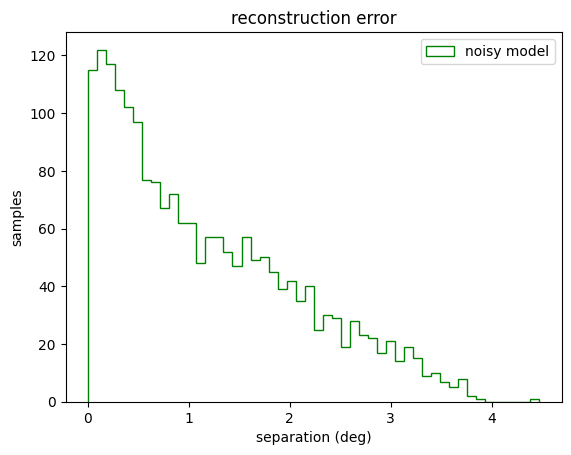

In [28]:
ax = plt.subplot()

# cumulative counts hist
data = err_noisy
ax.set_title('reconstruction error')
ax.hist(data, 50, density=False, histtype='step', color='g', label=['noisy model'])
ax.set_ylabel('samples')
ax.set_xlabel('separation (deg)')
ax.legend()

# Compare with cleaned model

In [30]:
# dataset 
if 'CLEAN' not in mapsname:
    mapsname = mapsname.replace('.npy', '_CLEAN.npy')
ds = np.load(mapsname, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]

# split data
train_data, train_labels, test_data, test_labels = split_regression_dataset(ds, split=80, reshape=True, 
                                                                            binning=binning)
# load model
if 'CLEAN' not in savename:
    savename = savename + '_CLEAN'
model = tf.keras.models.load_model(f'../models/{savename}.keras')
model.summary()

# predictions
predictions = model.predict(test_data) * binning
predictions[idx], test_labels[idx] * binning

(8000, 200, 200, 1) (8000, 2)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 197, 197, 2)       34        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 2)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 4)         36        
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 4)         68        
                                                                 
 conv2d_3 (Conv2D)           (None, 95, 95, 4)         68        
                                                                 
 conv2d_4 (Conv2D)           (None, 94, 94, 4)         68        
                          

(array([99.553986, 95.023705], dtype=float32),
 array([97.56725326, 91.5585346 ]))

In [31]:
err = []
s = len(train_data)
for pred, label in zip(predictions, test_labels):
    s += 1 
    row = infodata[infodata['seed']==s]
    # WCS coordinates
    w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
                point_ref=point_ref, pixelsize=pixelsize)
    # simulated coordinates
    true_deg = {'ra': row['source_ra'].values[0], 'dec': row['source_dec'].values[0]}
    true_pix = {'x': label[0], 'y': label[1]}
    # prediction coordinates
    sky = w.pixel_to_world(pred[0], pred[1])
    found_deg = {'ra': sky.ra.deg, 'dec': sky.dec.deg}
    # find separation in data
    true_sky = SkyCoord(ra=true_deg['ra'], dec=true_deg['dec'], unit='deg', frame='icrs')
    found_sky = SkyCoord(ra=found_deg['ra'], dec=found_deg['dec'], unit='deg', frame='icrs')
    err.append(true_sky.separation(found_sky))
    
err_clean = [e.degree for e in err]
len(err_clean)

2000

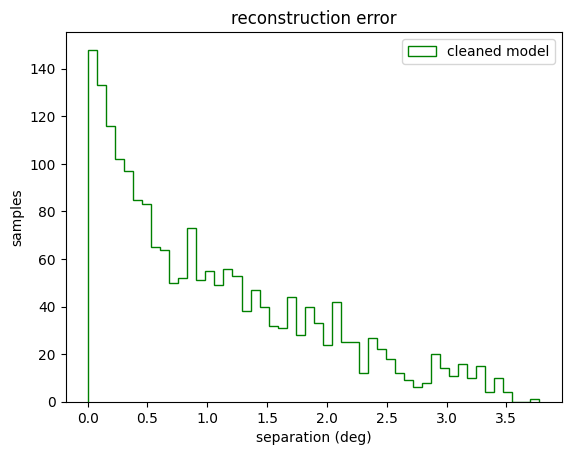

In [32]:
ax = plt.subplot()

# cumulative counts hist
data = err_clean
ax.set_title('reconstruction error')
ax.hist(data, 50, density=False, histtype='step', color='g', label=['cleaned model'])
ax.set_ylabel('samples')
ax.set_xlabel('separation (deg)')
ax.legend()

# Comparison hist

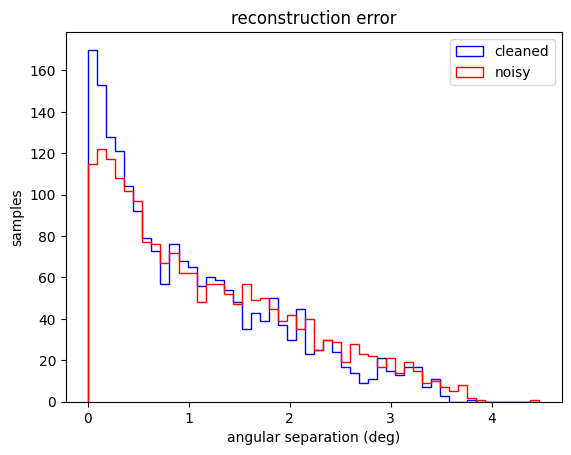

In [37]:
data = (err_noisy, err_clean)

ax = plt.subplot()
colors = ['red', 'blue'] 

# cumulative counts hist
ax.set_title('reconstruction error')
ax.hist(data, 50, density=False, histtype='step', color=colors, label=['noisy', 'cleaned'])
ax.set_ylabel('samples')
ax.set_xlabel('angular separation (deg)')
ax.legend()